<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practice/Practicing_on_Sarcasm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the Sarcasm Dataset**

In [12]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-10-21 12:03:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2020-10-21 12:03:34 (243 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [13]:
import json

with open("/tmp/sarcasm.json") as f:
    datastore = json.load(f)

# **2. Data Preprocessing**

In [14]:
headlines = []
urls = []
labels = []

for item in datastore:
    headlines.append(item["headline"])
    urls.append(item["article_link"])
    labels.append(item["is_sarcastic"])


print("Size of dataset: {}".format(len(headlines)))

Size of dataset: 26709


In [15]:
headlines[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [16]:
labels[:5]

[0, 0, 1, 1, 0]

In [17]:
oov_token = "<OOV>"
training_size = 20000
vocab_size = 10000
embedding_dim = 128
trunc_type = "post"
pad_type = "post"

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(headlines)

sequences = tokenizer.texts_to_sequences(headlines)
padded_sequences = pad_sequences(sequences, padding=pad_type, truncating=trunc_type)

max_len = len(padded_sequences[0])
print(max_len)

print("Headline : {}".format(headlines[0]))
print("Tokenized Sequence : {}".format(sequences[0]))
print("Padded Sequence : {}".format(padded_sequences[0]))

40
Headline : former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized Sequence : [308, 1, 679, 3337, 2298, 48, 382, 2576, 1, 6, 2577, 8434]
Padded Sequence : [ 308    1  679 3337 2298   48  382 2576    1    6 2577 8434    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [19]:
train_padded = np.array(padded_sequences[:training_size])
valid_padded = np.array(padded_sequences[training_size:])

train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

print(len(train_padded))
print(len(valid_padded))

20000
6709


In [20]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.legend([string, "val_" + string])
    plt.show()

# **Model with Multiple LSTM Layers**

In [25]:
from keras.regularizers import L2

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
    keras.layers.LSTM(32, dropout=0.2 ),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 128)           1280000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 64)            49408     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,341,857
Trainable params: 1,341,857
Non-trainable params: 0
____________________________________________

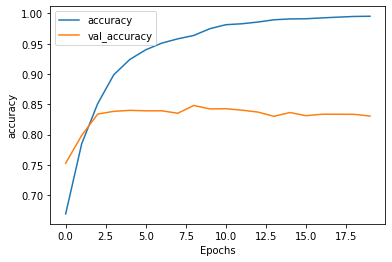

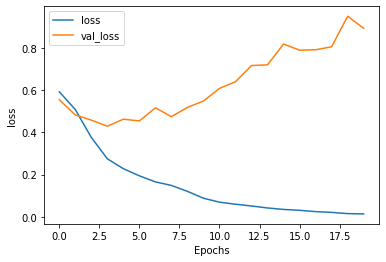

In [26]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [27]:
bidirectional_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True,
                                                 dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(16, dropout=0.2)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

bidirectional_model.summary()

bidirectional_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = bidirectional_model.fit(train_padded, train_labels, epochs=20, 
          validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 128)           1280000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 64)            41216     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,331,617
Trainable params: 1,331,617
Non-trainable params: 0
____________________________________________

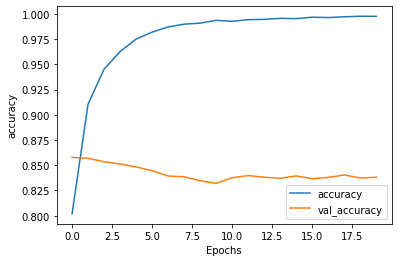

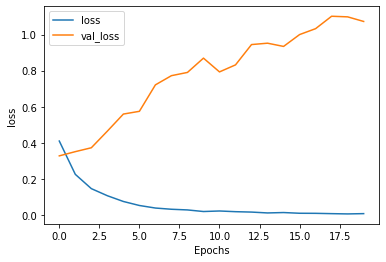

In [28]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")